<a href="https://colab.research.google.com/github/muhammadnurarasy/muhammadnurarasy.github.io/blob/main/Stock_Price_Prediction_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance pandas matplotlib


In [3]:
import yfinance as yf
import pandas as pd

# Define the stock ticker and the time period
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2022-01-01'

# Download the historical stock data
data = yf.download(ticker, start=start_date, end=end_date)

# Save the data to a CSV file
data.to_csv(f'{ticker}_stock_data.csv')

# Display the first few rows of the dataset
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402174,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714722,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716955,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049520,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973553,237458000


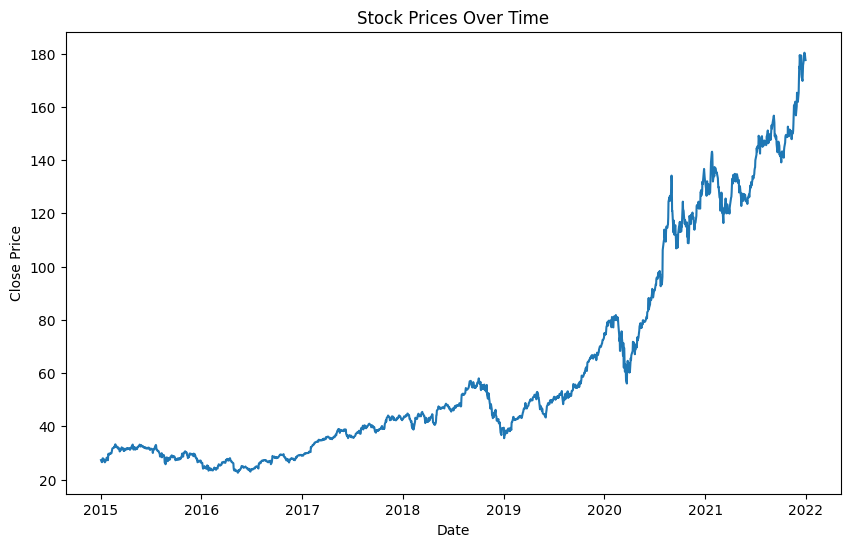

In [4]:
# Load the data
data = pd.read_csv(f'{ticker}_stock_data.csv', index_col='Date', parse_dates=True)

# Plot the closing prices
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


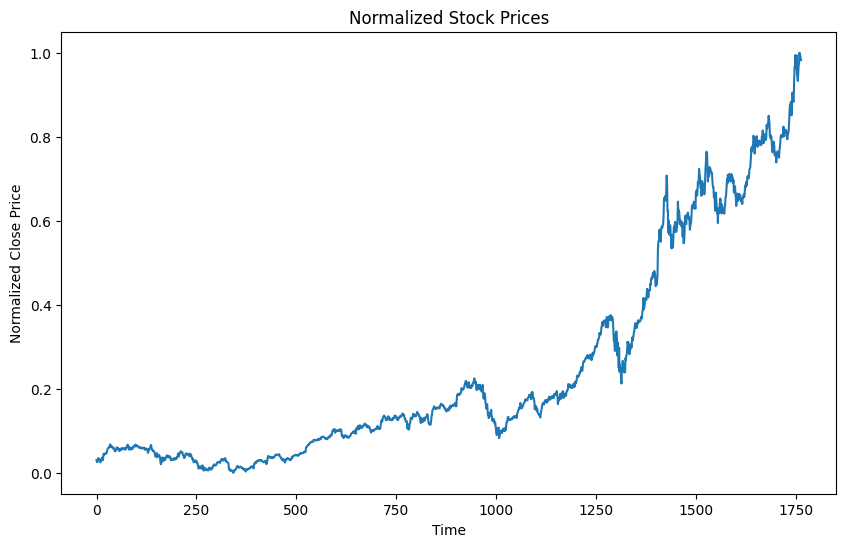

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(scaled_data)
plt.title('Normalized Stock Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Close Price')
plt.show()


In [6]:
import numpy as np

sequence_length = 60
x_data = []
y_data = []

for i in range(sequence_length, len(scaled_data)):
    x_data.append(scaled_data[i-sequence_length:i, 0])
    y_data.append(scaled_data[i, 0])

x_data, y_data = np.array(x_data), np.array(y_data)

# Reshape the data for LSTM
x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))

print(f'x_data shape: {x_data.shape}')
print(f'y_data shape: {y_data.shape}')


x_data shape: (1703, 60, 1)
y_data shape: (1703,)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [8]:
# Split the data into training and test sets
train_size = int(len(x_data) * 0.8)
x_train, y_train = x_data[:train_size], y_data[:train_size]
x_test, y_test = x_data[train_size:], y_data[train_size:]

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/50
43/43 [==============================] - 20s 90ms/step - loss: 0.0029 - val_loss: 0.0069
Epoch 2/50
43/43 [==============================] - 3s 79ms/step - loss: 5.2592e-04 - val_loss: 0.0018
Epoch 3/50
43/43 [==============================] - 2s 57ms/step - loss: 4.5849e-04 - val_loss: 0.0011
Epoch 4/50
43/43 [==============================] - 2s 55ms/step - loss: 4.7501e-04 - val_loss: 0.0023
Epoch 5/50
43/43 [==============================] - 2s 54ms/step - loss: 4.2410e-04 - val_loss: 0.0025
Epoch 6/50
43/43 [==============================] - 3s 61ms/step - loss: 3.9112e-04 - val_loss: 0.0028
Epoch 7/50
43/43 [==============================] - 4s 89ms/step - loss: 4.3237e-04 - val_loss: 9.3610e-04
Epoch 8/50
43/43 [==============================] - 2s 55ms/step - loss: 3.9896e-04 - val_loss: 0.0024
Epoch 9/50
43/43 [==============================] - 2s 54ms/step - loss: 3.5104e-04 - val_loss: 0.0029
Epoch 10/50
43/43 [==============================] - 2s 58ms/step - loss

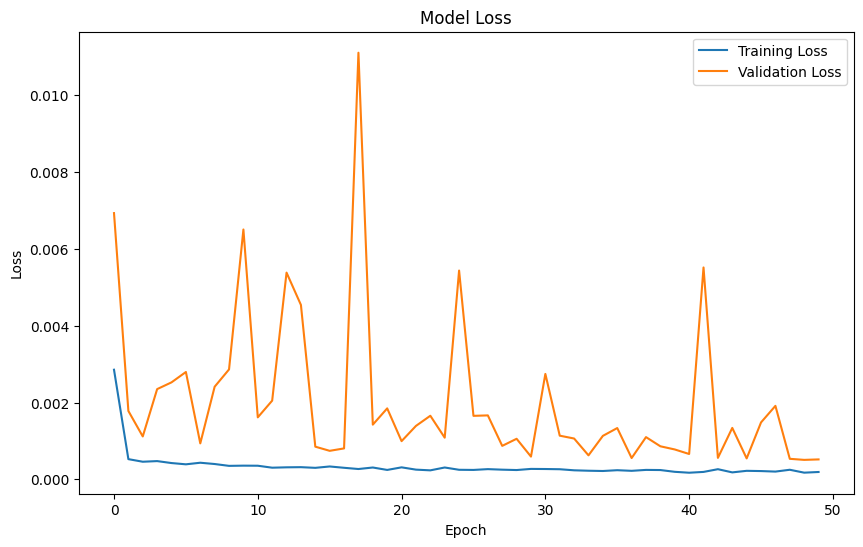

In [9]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


11/11 [==============================] - 0s 39ms/step


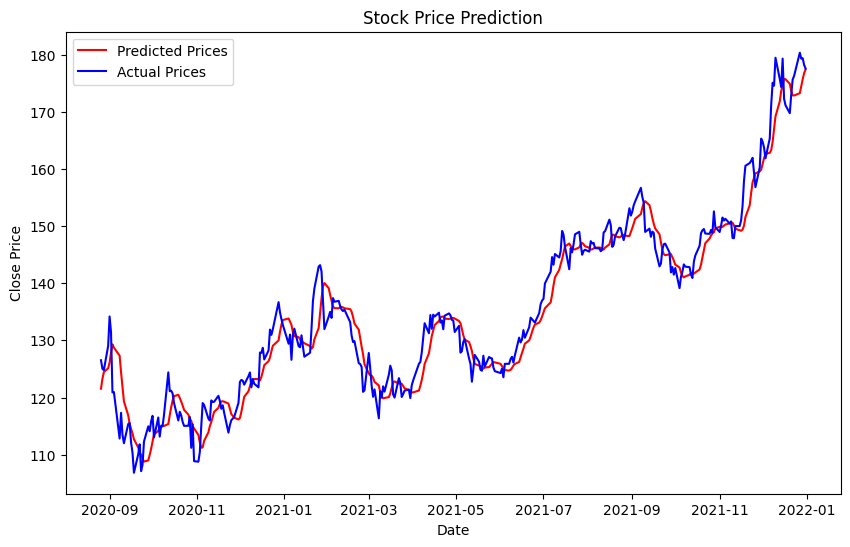

In [13]:
# Predict the stock prices
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot the predictions against the true values
plt.figure(figsize=(10, 6))
plt.plot(data.index[train_size + sequence_length:], predictions, color='red', label='Predicted Prices')
plt.plot(data.index[train_size + sequence_length:], data['Close'][train_size + sequence_length:], color='blue', label='Actual Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [11]:
model.save('stock_price_lstm_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load the trained model
model = load_model('/content/drive/MyDrive/Project/Stock Price LSTM/stock_price_lstm_model.h5')

# Function to fetch and preprocess data for a new ticker
def get_stock_data(ticker, start_date='2015-01-01'):
    data = yf.download(ticker, start=start_date)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return data, scaled_data, scaler

# Fetch data for the new ticker
new_ticker = 'GOOGL'
data, scaled_data, scaler = get_stock_data(new_ticker)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
def create_sequences(data, sequence_length=60):
    x_data = []
    for i in range(sequence_length, len(data)):
        x_data.append(data[i-sequence_length:i, 0])
    x_data = np.array(x_data)
    return x_data

# Create sequences from the scaled data
sequence_length = 60
x_data = create_sequences(scaled_data, sequence_length)

# Reshape data to fit the LSTM model input
x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))


In [17]:
def predict_future_prices(model, initial_data, num_predictions, scaler, sequence_length=60):
    predictions = []
    current_data = initial_data[-sequence_length:]

    for _ in range(num_predictions):
        current_data = np.reshape(current_data, (1, sequence_length, 1))
        predicted_price = model.predict(current_data)
        predictions.append(predicted_price[0, 0])
        current_data = np.append(current_data[0, 1:], predicted_price[0, 0])

    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Predict prices for the next 365 days (approx. 1 year)
num_predictions = 365
future_predictions = predict_future_prices(model, scaled_data, num_predictions, scaler)

# Generate dates for the predicted prices
last_date = data.index[-1]
prediction_dates = pd.date_range(last_date, periods=num_predictions)

# Create a DataFrame for plotting
future_df = pd.DataFrame(data=future_predictions, index=prediction_dates, columns=['Predicted Close'])


1/1 [==============================] - 0s 34ms/step


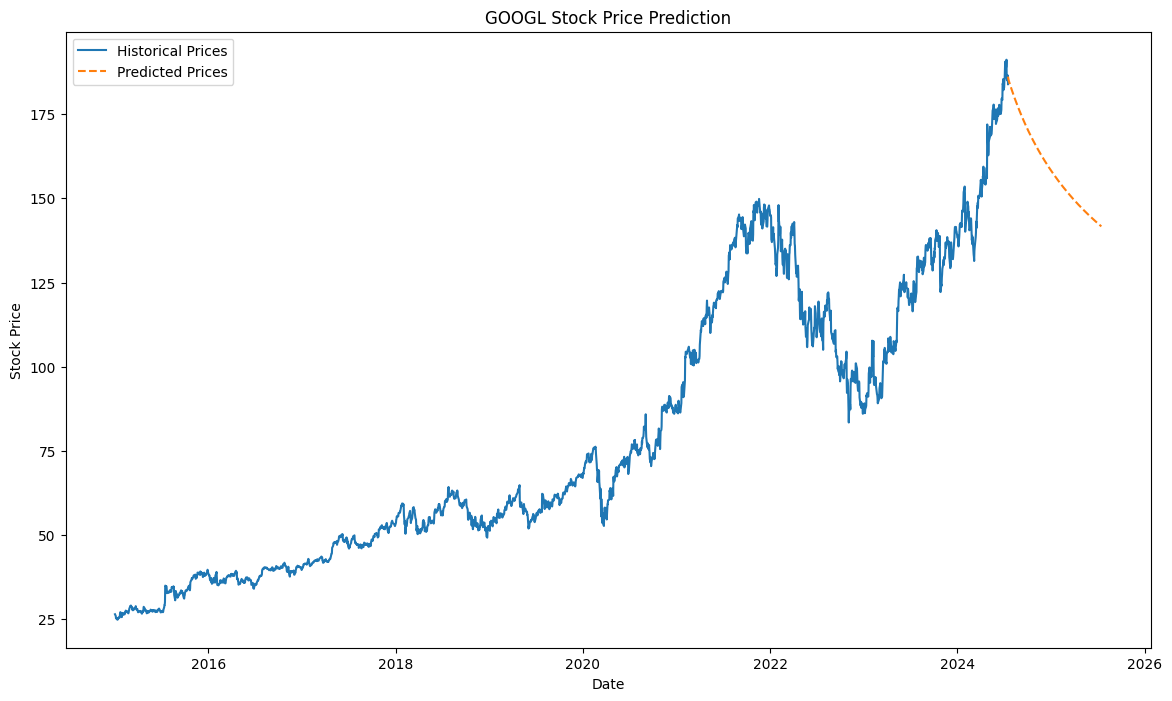

In [18]:
plt.figure(figsize=(14, 8))
plt.plot(data['Close'], label='Historical Prices')
plt.plot(future_df['Predicted Close'], label='Predicted Prices', linestyle='--')
plt.title(f'{new_ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
